# Test Saved Models

This notebook loads the best models from tasks 1 and 3 and evaluates them on test data.

In [1]:
import joblib
import pandas as pd
import numpy as np
import scipy.sparse
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

## Load Data

In [2]:
# Load test data
print("Loading test data...")
df_test = pd.read_csv('scitweets_export.tsv', sep='\t')

Loading test data...


## Test Task 1 Model (Science Related Classification)

Loading Task 1 model...

Task 1 results saved to 'test_saved_mod_task1.csv'


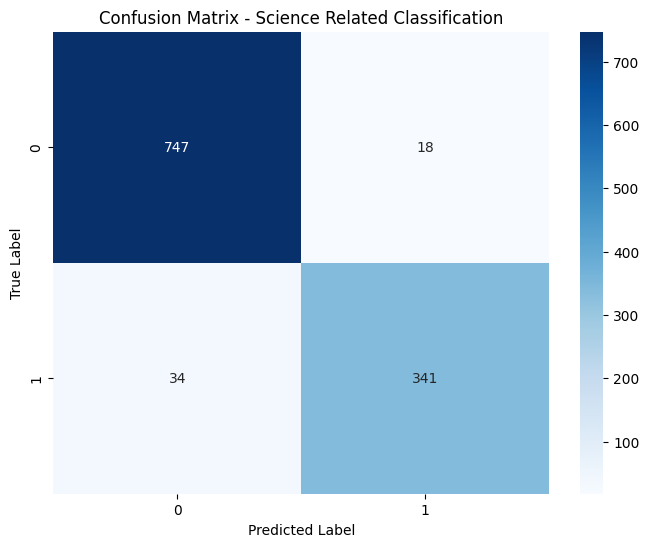


Analyzing false predictions...

Total false predictions: 52

Sample of misclassified tweets:


,Text,True_Label,Predicted_Label
83,"Law leads to guilt,guilt leads to struggle,str...",1,0
112,LEED-certified buildings are often less energy...,1,0
126,@SenatorParker New York State must not set a p...,1,0
145,@Bruciebabe @WillardFoxton @doxievee @Nicksb36...,0,1
162,Overthinking leads to negative thoughts.,1,0
197,Perfect teeth are a turn on,1,0
234,Check out B HEALING STONE & MAGNET PILLOW (THE...,1,0
239,Cassini confirms hydrothermal activity in ocea...,1,0
253,coumadin decreased sex drive men http://t.co/z...,1,0
269,'Virgin-born' sawfish are a first in the wild ...,1,0


In [3]:
def prepare_features_task1(df, saved_model):
    """Prepare features for task 1 prediction"""
    # Add binary features
    df['text'] = df['text'].apply(lambda x: emoji.demojize(str(x)))
    df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
    df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
    df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
    df['has_emoji'] = df['text'].str.contains(r':[^:\s]+:')
    
    # Get text features using saved vectorizer
    X_text = saved_model['vectorizer'].transform(df['text'])
    
    # Binary features
    extra_features = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
    X_extra = scipy.sparse.csr_matrix(extra_features.values)
    
    # Combine features
    X = scipy.sparse.hstack([X_text, X_extra])
    
    return X

# Load saved model for task 1
print("Loading Task 1 model...")
saved_model_task1 = joblib.load('best_model_task1.joblib')

# Prepare features
X_test_task1 = prepare_features_task1(df_test, saved_model_task1)

# Convert to dense array if using Gaussian NB or XGBoost
if isinstance(saved_model_task1['model'], (GaussianNB, XGBClassifier)):
    X_test_task1 = X_test_task1.toarray()

# Make predictions
predictions_task1 = saved_model_task1['model'].predict(X_test_task1)

# Create results DataFrame
results_task1 = pd.DataFrame({
    'True_Label': df_test['science_related'],
    'Predicted_Label': predictions_task1,
    'Text': df_test['text']
})

# Save results
results_task1.to_csv('test_saved_mod_task1.csv', index=False)
print("\nTask 1 results saved to 'test_saved_mod_task1.csv'")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(results_task1['True_Label'], results_task1['Predicted_Label'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Science Related Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Show false predictions
print("\nAnalyzing false predictions...")
false_predictions = results_task1[results_task1['True_Label'] != results_task1['Predicted_Label']]
print(f"\nTotal false predictions: {len(false_predictions)}")
print("\nSample of misclassified tweets:")
display(false_predictions[['Text', 'True_Label', 'Predicted_Label']].head(10))

## Test Task 3 Model (Claim vs Reference vs Context)

Loading Task 3 model...

Task 3 results saved to 'test_saved_mod_task3.csv'


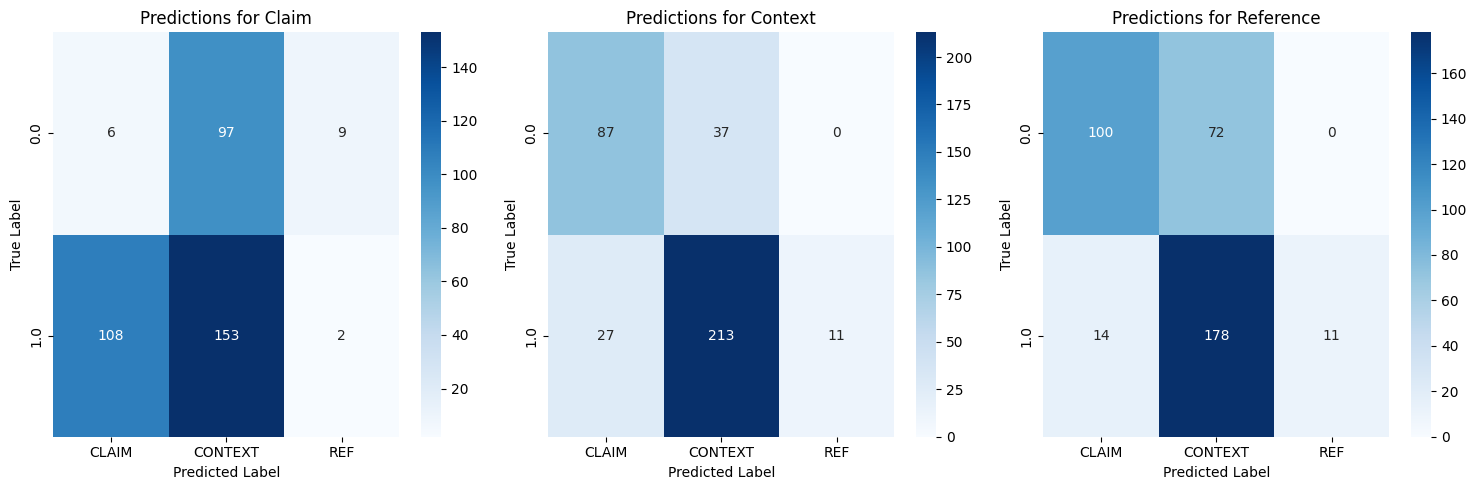


Analyzing false predictions...

Total misclassified tweets: 259

Sample of misclassified tweets:


,Text,True_Label_Claim,True_Label_Context,True_Label_Ref,Predicted_Label
4,Does daily routine help prevent problems with ...,1.0,0.0,0.0,CONTEXT
6,“Traffic Jam” In Brain’s Neurons Could Be Caus...,1.0,1.0,1.0,CONTEXT
7,Can playing more games improve lives and save ...,1.0,0.0,0.0,CONTEXT
8,The effect of climate change on iceberg produc...,0.0,1.0,1.0,CONTEXT
14,@RepCohen @SenAlexander @SenBobCorker pls supp...,0.0,1.0,0.0,CLAIM
30,Caution! 3D Printers Could Cause Health Proble...,1.0,0.0,0.0,CONTEXT
32,MDLinx Blog: MDLinx Blog: Neuropsychological f...,0.0,1.0,1.0,CONTEXT
38,@najdi_outsider @mayami2012 @mol7daa @ahlamm4 ...,1.0,1.0,0.0,CLAIM
40,Sleep 'boosts brain cell numbers' http://t.co/...,1.0,1.0,1.0,CONTEXT
43,Versatile microRNAs Choke Off Cancer Blood Sup...,1.0,1.0,1.0,CONTEXT


In [5]:
def prepare_features_task3(df, saved_model):
    """Prepare features for task 3 prediction"""
    # Add binary features
    df['text'] = df['text'].apply(lambda x: emoji.demojize(str(x)))
    df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
    df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
    df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
    df['has_emoji'] = df['text'].str.contains(r':[^:\s]+:')
    
    # Get TF-IDF features
    X_text = saved_model['vectorizer'].transform(df['text'])
    
    # Binary features
    extra_features = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
    X_extra = scipy.sparse.csr_matrix(extra_features.values)
    
    # Combine features
    X = scipy.sparse.hstack([X_text, X_extra])
    
    return X

# Load saved model for task 3
print("Loading Task 3 model...")
saved_model_task3 = joblib.load('best_model_task3.joblib')

# Filter scientific tweets
df_test_sci = df_test[df_test['science_related'] == 1].copy()

# Prepare features
X_test_task3 = prepare_features_task3(df_test_sci, saved_model_task3)

# Convert to dense array if using Gaussian NB or XGBoost
if isinstance(saved_model_task3['model'], (GaussianNB, XGBClassifier)):
    X_test_task3 = X_test_task3.toarray()

# Make predictions
predictions_task3 = saved_model_task3['model'].predict(X_test_task3)

# Create mapping for readable labels
label_map = {0: "CLAIM", 1: "CONTEXT", 2: "REF"}

# Create results DataFrame
results_task3 = pd.DataFrame({
    'True_Label_Claim': df_test_sci['scientific_claim'],
    'True_Label_Context': df_test_sci['scientific_context'],
    'True_Label_Ref': df_test_sci['scientific_reference'],
    'Predicted_Label': [label_map[p] for p in predictions_task3],
    'Text': df_test_sci['text']
})

# Save results
results_task3.to_csv('test_saved_mod_task3.csv', index=False)
print("\nTask 3 results saved to 'test_saved_mod_task3.csv'")

# Create visualization for each category
plt.figure(figsize=(15, 5))
categories = ['Claim', 'Context', 'Reference']
true_labels = ['True_Label_Claim', 'True_Label_Context', 'True_Label_Ref']

for i, (cat, true_label) in enumerate(zip(categories, true_labels), 1):
    plt.subplot(1, 3, i)
    confusion = pd.crosstab(results_task3[true_label], results_task3['Predicted_Label'])
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Predictions for {cat}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Analyze false predictions
print("\nAnalyzing false predictions...")
false_predictions = results_task3[
    ((results_task3['True_Label_Claim'] == 1) & (results_task3['Predicted_Label'] != 'CLAIM')) |
    ((results_task3['True_Label_Context'] == 1) & (results_task3['Predicted_Label'] != 'CONTEXT')) |
    ((results_task3['True_Label_Ref'] == 1) & (results_task3['Predicted_Label'] != 'REF'))
]

print(f"\nTotal misclassified tweets: {len(false_predictions)}")
print("\nSample of misclassified tweets:")
display(false_predictions[[
    'Text', 
    'True_Label_Claim', 
    'True_Label_Context', 
    'True_Label_Ref', 
    'Predicted_Label'
]].head(10))